In [1]:
import shap
import torch
import yaml
from argparse import Namespace
import numpy as np
import pandas as pd
import time
from data_pre.data_loader import PropertyPredictionDataModule
from data_pre.tokenizer import MolTranBertTokenizer
from model.layers.main_layer import LightningModule
from fast_transformers.masking import LengthMask as LM
import matplotlib.pyplot as plt
from sklearn import linear_model

def prepare_data(model_name):

     with open(f'Pretrained MoLFormer/hparams/{model_name}.yaml', 'r') as f:
        config = Namespace(**yaml.safe_load(f))
        
        # prepare data:
        data_module = PropertyPredictionDataModule(config)
        data_module.prepare_data()

        # data all loader
        train_loader = data_module.train_dataloader()
        test_loader = data_module.val_dataloader()[1]

        return test_loader,train_loader

def prepare_model(model_name):
        
        with open(f'Pretrained MoLFormer/hparams/{model_name}.yaml', 'r') as f:
        
            config = Namespace(**yaml.safe_load(f))

            tokenizer = MolTranBertTokenizer('bert_vocab.txt')

            ckpt = f'Pretrained MoLFormer/checkpoints/{model_name}.ckpt'

            model = LightningModule(config, tokenizer).load_from_checkpoint(ckpt, strict=False,config=config, tokenizer=tokenizer,vocab=len(tokenizer.vocab))

            # Check for GPU availability
            device = torch.device('cuda')
            model = model.to(device)  # Move model to GPU if available
            model.eval()
            
            return model
        
idx_size = 70
mask_size = 70 + idx_size
mz_size = 1 + mask_size
adduct_size = 1 + mz_size
ecfp_size =1024 + adduct_size

model_name = 'XL_871'
model = prepare_model(model_name)
model.eval()


def predict(batch):
    with torch.no_grad():

        idx = batch[0]# idx
        mask = batch[1]# mask
        m_z = batch[2] # m/z
        adduct = batch[3] # adduct
        ecfp = batch[4] # ecfp
        targets = batch[-1] # ccs
    
        device = 'cuda'
        # 确保 data 是一个 numpy 数组，然后将其转化为 torch 张量

        idx, mask, m_z, adduct, ecfp,_ = [x.to(device) for x in batch]

        x = model.tok_emb(idx)
        x = model.blocks(x)
        # x = model.aggre(x, m_z, adduct, ecfp)

        input_mask_expanded = mask.unsqueeze(-1).expand(x.size()).float()
        masked_embedding = x * input_mask_expanded
        sum_embeddings = torch.sum(masked_embedding, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-8)
        loss_input = sum_embeddings / sum_mask
        pred = model.aggre(loss_input, m_z, adduct, ecfp)   


    return pred.cpu().detach().numpy()

def print_accuracy(f,x_test,y_test):
    print(f"Root mean squared test error = {np.sqrt(np.mean((f(x_test) - y_test) ** 2))}")
    time.sleep(0.5)  # to let the print get out before any progress bars


`fused_weight_gradient_mlp_cuda` module not found. gradient accumulation fusion with weight gradient computation disabled.


Net layer dropout is 0.0
Net layer dropout is 0.0


In [2]:

if __name__ == '__main__':
    emb_output = []
    truth = []
    test_dataloader, train_dataloader = prepare_data(model_name)
    # c=
    # device = 'cuda'
    for batch in train_dataloader:
    
        pred = predict(batch)
        emb_output.extend(pred)
        truth.extend(batch[-1].cpu().detach().numpy())


    x_train = np.stack(emb_output)
    y_train =  np.stack(truth)

    test_pred = []
    test_y = []
    for test_batch in test_dataloader:

        pred = predict(test_batch)
        test_pred.extend(pred)
        test_y.extend(test_batch[-1].cpu().detach().numpy()) 
    test_y  = np.stack(test_y)
    test_pred  = np.stack(test_pred)

    print(test_pred.shape)
    print(test_y.shape)


Inside prepare_dataset
Length of dataset: 41816
<class 'pandas.core.frame.DataFrame'>
Int64Index: 41816 entries, 0 to 41815
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Molecule Name  41816 non-null  object 
 1   CCS_AVG        41816 non-null  float64
 2   Adduct         41816 non-null  object 
 3   Dimer.1        41816 non-null  object 
 4   inchi          41816 non-null  object 
 5   smiles         41816 non-null  object 
 6   m/z            41816 non-null  float64
 7   ecfp           41816 non-null  object 
dtypes: float64(2), object(6)
memory usage: 2.9+ MB
Length of dataset: 5804
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5804 entries, 0 to 5803
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Molecule Name  5804 non-null   object 
 1   CCS_AVG        5804 non-null   float64
 2   Adduct         5804 non-null   object 
 3

Root mean squared test error = 6.697329044342041


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

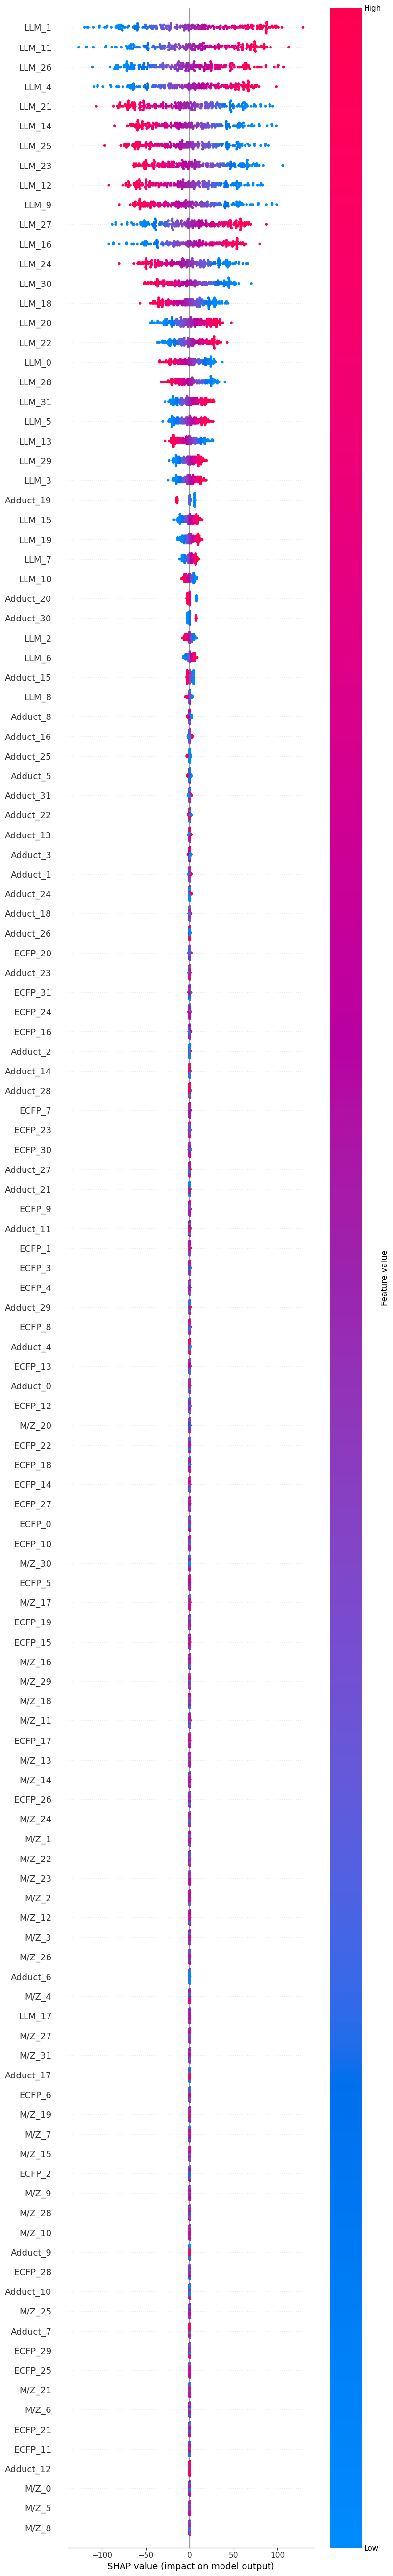

In [3]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(x_train, y_train)  

print_accuracy(lin_regr.predict,test_pred,test_y)

f_size = 32 
features_name = [f"{prefix}_{n}" for prefix in ["LLM", "ECFP", "Adduct","M/Z"] for n in range(f_size)]

# X_train_summary = shap.kmeans(x_train, 10)

ex = shap.KernelExplainer(lin_regr.predict, x_train[:200])
shap_values = ex.shap_values(test_pred[:200])
# shap_values = ex.shap_values(x_train[0, :])

shap.initjs()
shap.summary_plot(shap_values, test_pred[:200],features_name[:200],max_display=128)
# shap.save_html("test.html", shap.force_plot(
#     float(ex.expected_value),  # 转换expected_value 
#     shap_values.astype(float),  # 转换SHAP值
#     x_train[0, :].astype(float)  # 转换输入数据
# ))

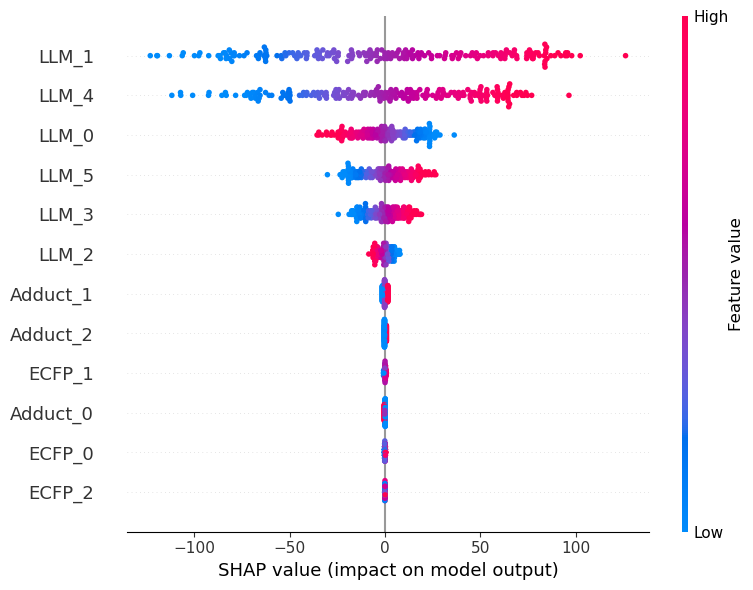

In [85]:
# 1. 确定需要显示的特征索引
selected_indices = list(range(6)) + list(range(32, 35)) + list(range(64, 67))  # 前10个和第30-40个特征

# 2. 筛选 SHAP 值和特征名称
shap_values_selected = shap_values[:, selected_indices]  # 筛选 SHAP 值
features_name_selected = [features_name[i] for i in selected_indices]  # 筛选特征名称

# 3. 筛选测试数据的特征列
test_pred_selected = test_pred[:200, selected_indices]  # 筛选相同的特征列

# 4. 绘制 SHAP 摘要图
shap.summary_plot(
    shap_values_selected,  # 筛选后的 SHAP 值
    test_pred_selected,    # 筛选后的测试数据
    feature_names=features_name_selected,  # 筛选后的特征名称
    max_display=len(selected_indices),  # 显示所有筛选后的特征,
    plot_size=(8, 6)
)

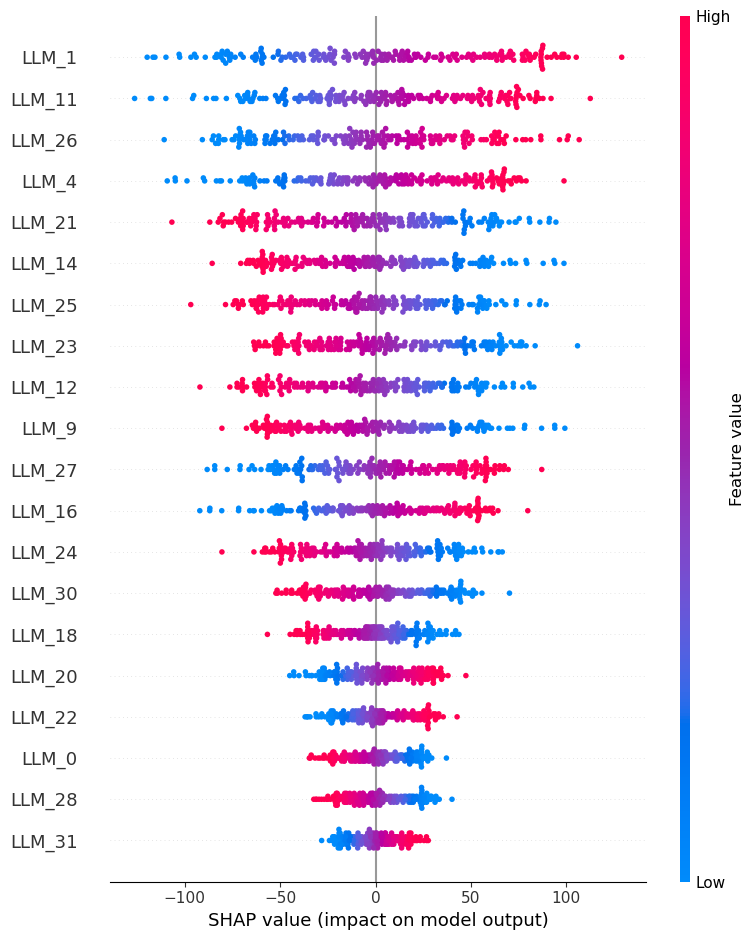

In [4]:
shap.summary_plot(shap_values, test_pred[:200],features_name[:200],max_display=20)

In [5]:
shap.save_html("force_plot_200.html",shap.force_plot(ex.expected_value, shap_values[0:200, :], test_pred[0:200, :]))

In [49]:
from shap.maskers import Independent
# 创建一个 masker
masker = Independent(test_pred)  # X_train 是训练数据
explainer = shap.Explainer(lin_regr.predict,masker)
shap_values= explainer(test_pred[:200])

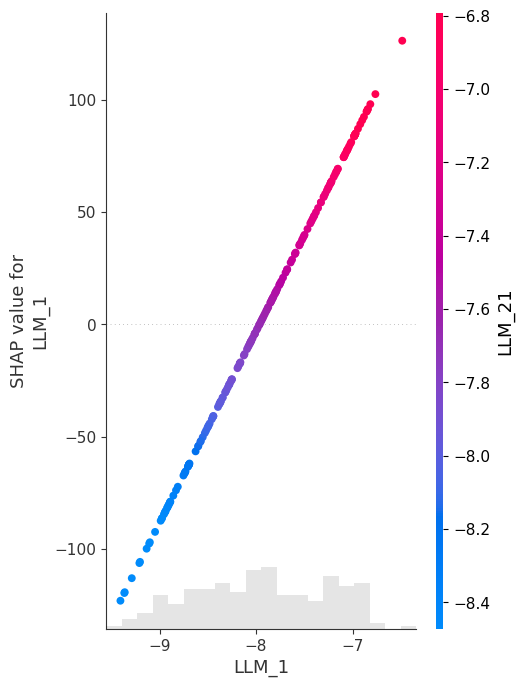

In [113]:
shap_values.feature_names =features_name
shap.plots.scatter(shap_values[:,1], color=shap_values,dot_size=32,show=False)  # 关闭自动显示，便于后续调整

# 2. 获取当前画布并修改尺寸
current_fig = plt.gcf()
current_fig.set_size_inches(5, 8)  # 设置宽度和高度（单位：英寸）

# 3. 手动显示图像
plt.show()
                   

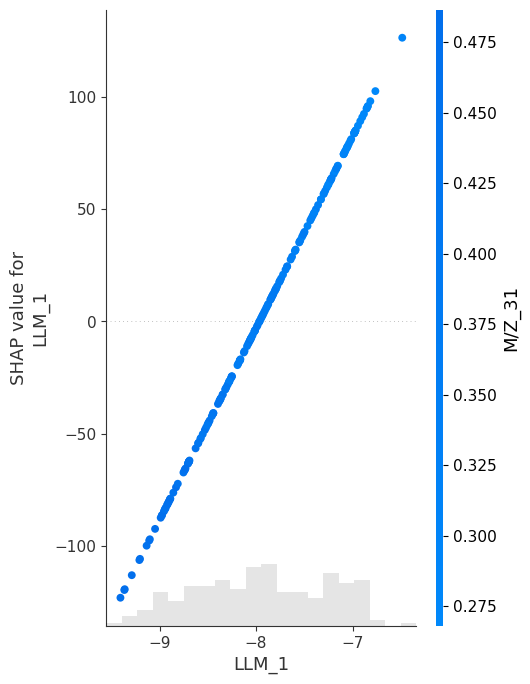

In [116]:
from matplotlib.colors import LinearSegmentedColormap

shap_values.feature_names =features_name
# 自定义全蓝色颜色条（从浅蓝到深蓝）
colors = [ (0.0, 0.533, 0.980),(0.008, 0.435, 0.925)]  # RGB 格式
cmap_blue = LinearSegmentedColormap.from_list('custom_blue', colors)


shap.plots.scatter(shap_values[:,1], color=shap_values[:,40:],cmap=cmap_blue,dot_size=32,show=False)
# 2. 获取当前画布并修改尺寸
current_fig = plt.gcf()
current_fig.set_size_inches(5, 8)  # 设置宽度和高度（单位：英寸）

# 3. 手动显示图像
plt.show()

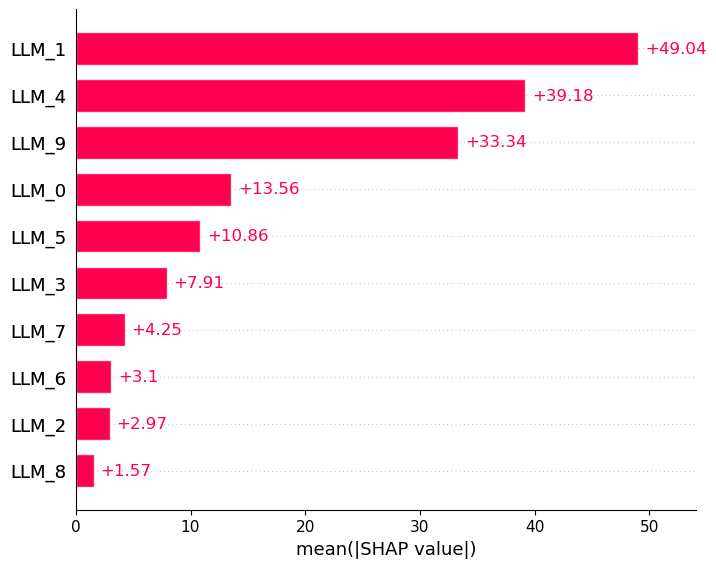

In [51]:
shap.plots.bar(shap_values[:,:10])

In [52]:
clustering = shap.utils.hclust(test_pred, test_y)

KeyboardInterrupt: 

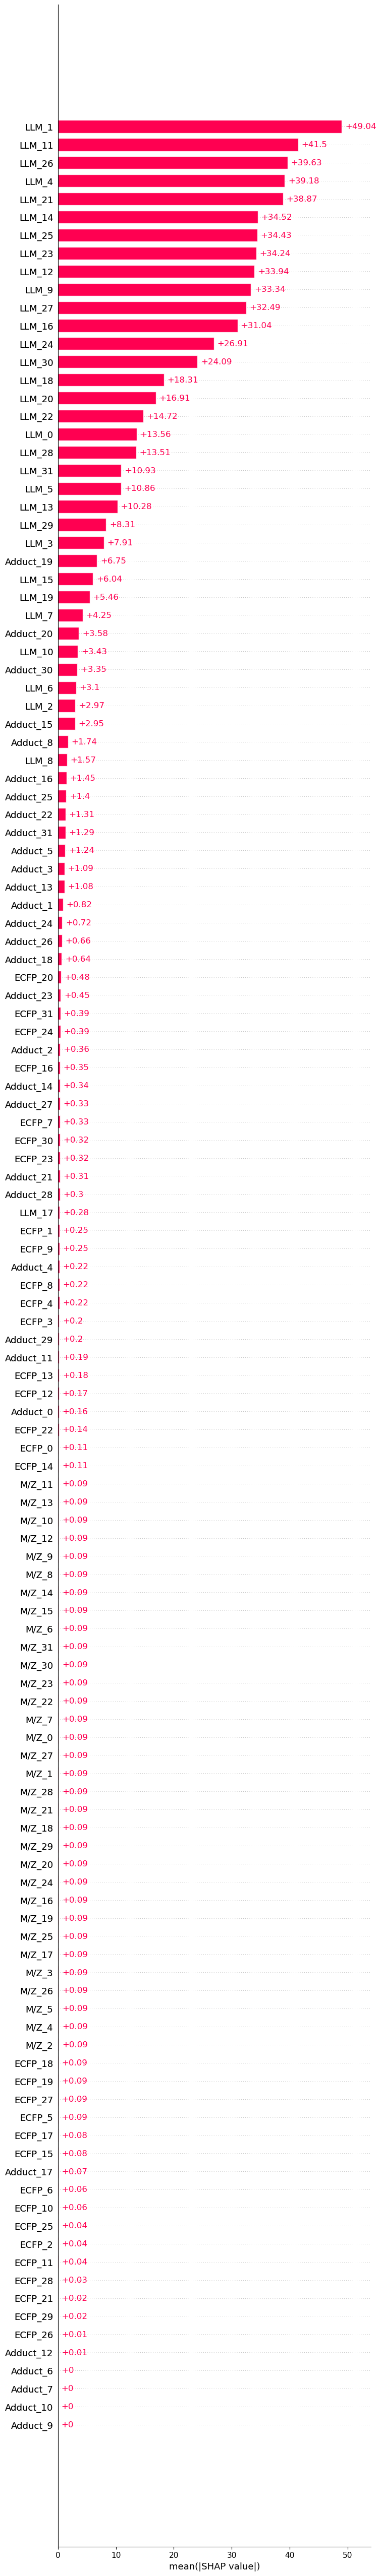

In [119]:
# shap.plots.bar(shap_values, clustering=clustering,clustering_cutoff=0.8)
shap.plots.bar(shap_values,max_display=128)

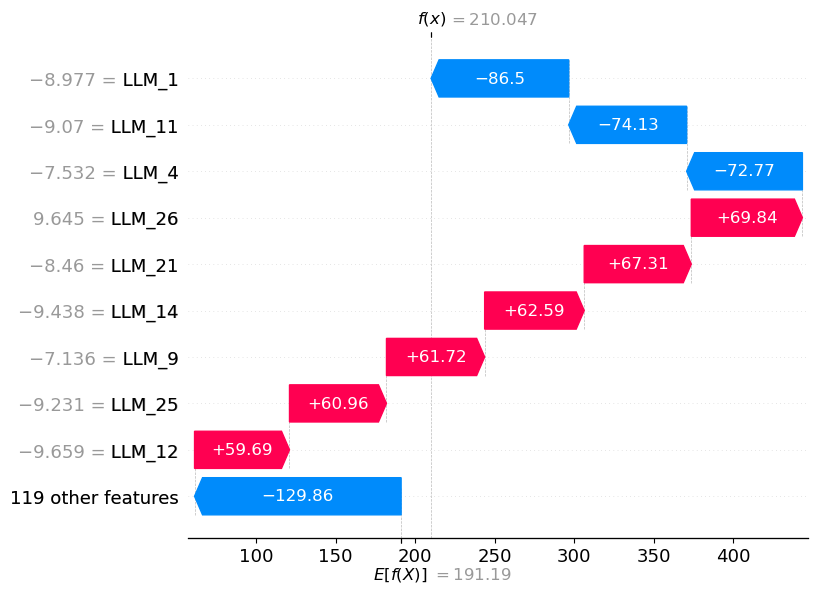

In [60]:
shap.plots.waterfall(shap_values[10])

In [62]:
shap.save_html("force_plot_llm.html",shap.plots.force(shap_values[10]))